Тематическое моделирование на данных Вконтакте: использование модели LDA, визуализация топиков, построение тематических профилей.

Цель: Боевой проект по тематическому моделированию. Цель - построить LDA модель и получить интерпретируемые топики. Попробовать посчитать тематические профили и получить их визуализацию на двумерной плоскости при помощи TSNE
В материалах вы можете найти выгрузку комментариев из разных музыкальных групп ВК, в полях music_style и performer можно получить информацию о конкретном музыкальном жанре и исполнителе, в группе которого был написан комментарий. Выгрузка уменьшенная, остались только комментарии длиной больше 40 слов, но тем не менее это всё ещё 500Мб, так что модельки будут считаться долго. Для отладки рекомендую брать небольшую выборку из этого датасета, чтобы на ней тестировать свой код.

Если у вас есть собственный датасет - можно (и будет очень-очень интересно) использовать его :)

1. Загрузите датасет. Если используете данные вк, то после загрузки воспользуйтесь следующим кодом:

from ast import literal_eval
bag_of_words = data.text_bow.apply(literal_eval)

где data - это загруженный датасет. Операция необходима, так как предварительно уже была проведена предобработка текстов и получено представление bag-of-words, так что остаётся его лишь прочитать из датасета

2. Используя gensim, добавьте биграммы к имеющемуся bag_of_words представлению

3. Составьте словарь из терминов (corpora.Dictionary)

4. По словарю терминов при помощи метода filter_extremes проведите фильтрацию слов по частоте встречаемости. На данных вк рекомендую следующие параметры: (no_below=3, no_above=0.4, keep_n=3*10**6)

5. Наконец, составьте итоговый корпус документов при помощи метода doc2bow. Рекомендую его сохранить (например, в pickle формате), на случай, если что-то где-то пойдет не так

6. По получившемуся корпусу постройте LDA модель, если используете данные вк, рекомендую параметры (eval_every=20, num_topics=30, passes=5). Не забудьте сохранить саму модель и её аттрибут expElogBeta, также при помощи метода show_topics возьмите по 100 самых вероятных слов для каждой темы

7. При помощи wordcloud визуализируйте каждый из получившихся топиков и попробуйте их проинтерпретировать. Чтобы не возиться долго с функциями для визуализации, можно взять их отсюда - https://github.com/DmitrySerg/top-russian-music/blob/master/models/clean_visualization.ipynb

8. Наконец, постройте тематические профили по интересующим вас группировкам (в случае с вк можно построить средние тематические вектора по жанрам или по исполнителям, если у вас собственные данные, попробуйте подумать, как можно было бы сгруппировать ваши документы, чтобы все-таки построить профили групп), и визуализируйте их при помощи TSNE

9. Вы великолепны
Критерии оценки: Получилось построить LDA и хотя бы в текстовом формате показать наиболее характерные для каждого топика слова - 5 баллов

Есть визуализация wordcloud +2 балла

Есть визуализация TSNE для тематических профилей +3 балла

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


import nltk
from nltk.corpus import stopwords 
nltk.download('stopwords')

import pickle

import gensimq
import gensim.corpora as corpora

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Valeria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('reduced_comments_vk.csv')

In [3]:
df.head()

Unnamed: 0 audio     author              comment_id                 date  \
0           9   NaN  146608415  52228413_282387_282503  2019-01-01 17:43:48   
1         103   NaN  197130573  52228413_282259_282287  2018-12-31 13:47:29   
2         107   NaN  -52228413  52228413_282158_282162  2018-12-30 21:04:56   
3         130   NaN  197130573  52228413_282158_282211  2018-12-30 23:04:28   
4         190   NaN  208434900  52228413_282010_282031  2018-12-29 17:18:25   

                                          dirty_text  \
0  [id415608045|Иван],\nВ который раз, весь мир л...   
1  С Наступающим!. Пусть старый год уходя оставит...   
2  Автор музыки и слов - Дмитрий Митькин.\n\nВ ко...   
3  Ура!!!🔥🔥🔥🔥🔥🔥🔥🔥 Предновогодняя премьера от непо...   
4  Легко. "Аминь"- лучший клип ГВ за последнее вр...   

                                 emoji  likes link music_style performer  \
0                                  NaN      1  NaN     estrada      лепс   
1                                  NaN      2  NaN     estrada      лепс   
2                                  NaN     29  NaN     estrada      лепс   
3  🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥🔥👍👍👍👍👍👍👍👍💪💪💪💪💪💪💪💪🔥🔥😎😎😎      6  NaN     estrada      лепс   
4                                  NaN      4  NaN     estrada      лепс   

   stickers                                               text video  \
0       NaN  id415608045 иван который весь мир лететь чужое...   NaN   
1       NaN  наступать пусть старый год уходить оставить ве...   NaN   
2       NaN  автор музыка слово дмитрий митькина который ве...   NaN   
3       NaN  ура предновогодний премьера неподражаемый непр...   NaN   
4       NaN  легко аминь хороший клип последний время полны...   NaN   

                                            text_bow  comment_len  
0  ['id415608045', 'иван', 'который', 'весь', 'ми...         79.0  
1  ['наступать', 'пусть', 'старый', 'год', 'уходи...         42.0  
2  ['автор', 'музыка', 'слово', 'дмитрий', 'митьк...         82.0  
3  ['ура', 'предновогодний', 'премьера', 'неподра...         43.0  
4  ['легко', 'аминь', 'хороший', 'клип', 'последн...         70.0

In [4]:
from ast import literal_eval 
bag_of_words = df.text_bow.apply(literal_eval)

Используя gensim, добавьте биграммы к имеющемуся bag_of_words представлению

In [5]:
bigram = gensim.models.Phrases(bag_of_words, min_count=5, threshold=10) # higher threshold fewer phrases.

# Составление биграм
bigram_mod = gensim.models.phrases.Phraser(bigram)
bigram_mod.save('bigram_mod.pkl')
    
data_words_bigrams = [bigram_mod[w] for w in bag_of_words]

Составьте словарь из терминов (corpora.Dictionary)

По словарю терминов при помощи метода filter_extremes проведите фильтрацию слов по частоте встречаемости. На данных вк рекомендую следующие параметры: (no_below=3, no_above=0.4, keep_n=310*6)

Наконец, составьте итоговый корпус документов при помощи метода doc2bow. Рекомендую его сохранить (например, в pickle формате), на случай, если что-то где-то пойдет не так

In [6]:
dictionary = corpora.Dictionary(data_words_bigrams)
dictionary.filter_extremes(no_below=3, no_above=0.4, keep_n=310*6)
corpus = [dictionary.doc2bow(text) for text in data_words_bigrams]

По получившемуся корпусу постройте LDA модель, если используете данные вк, рекомендую параметры (eval_every=20, num_topics=30, passes=5). Не забудьте сохранить саму модель и её аттрибут expElogBeta, также при помощи метода show_topics возьмите по 100 самых вероятных слов для каждой темы.

При помощи wordcloud визуализируйте каждый из получившихся топиков и попробуйте их проинтерпретировать. Чтобы не возиться долго с функциями для визуализации, можно взять их отсюда - https://github.com/DmitrySerg/top-russian-music/blob/master/models/clean_visualization.ipynb

In [7]:
lda_model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=30, 
        passes=5)

In [8]:
words_by_topic = lda_model.show_topics(num_topics=30, num_words=100, formatted=False)

In [9]:
prepare = True

In [11]:
if prepare == True: 
    lda_model.save("lda_model")

    with open('lda_model_topics_and_words', 'wb') as f:
        pickle.dump(words_by_topic, f)
    with open('corpus', 'wb') as f:
        pickle.dump(corpus, f)
        
else: 
    with open('corpus', 'rb') as f:
        corpus = pickle.load(f)
            
    with open('lda_model_topics_and_words', 'rb') as f:
        words_by_topic = pickle.load(f)
        
    with open('lda_model', 'rb') as f:
        lda_model = pickle.load(f)

    
    expElogbeta = np.load('lda_model.expElogbeta.npy')
    lda_model.expElogbeta = expElogbeta

In [12]:
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in words_by_topic]
topics_words_clean = [x[1:] for x in topics_words]
topics_words_clean[0]

(['твой',
  'ты',
  'хотеть',
  'https_com',
  'знаешь',
  'быть',
  'мой',
  'вася',
  'пацан',
  'сказать',
  'написать',
  'знать',
  'каждый_день',
  'слово',
  'навсегда',
  'слушай',
  'каждый',
  'я',
  'смочь',
  'привет',
  'крутой',
  'делать',
  'рассказать',
  'свой',
  'найти',
  'просто',
  'любить',
  'писать',
  'сначала',
  'мочь',
  'послушать',
  'наверно',
  'победить',
  'тысяча',
  'чувствовать',
  'давать',
  'добиться',
  'назвать',
  'помнить',
  'удача',
  'произойти',
  'подруга',
  'быть_счастливый',
  'нужный',
  'весело',
  'поговорить',
  'стать',
  'нерв',
  'город',
  'уверенный',
  'готовый',
  'следующий',
  'читать',
  'пойти',
  'ряд',
  'друг',
  'забыть',
  'болеть',
  'кайф',
  'звать',
  'дать',
  'семь',
  'самый',
  'доказать',
  'общий',
  'идти',
  'прочитать',
  'думать',
  'попасть',
  'ответить',
  'предел',
  'искать',
  'макс',
  'учить',
  'увидеть',
  'никто',
  'кумир',
  'один',
  'просить',
  'который',
  'господь',
  'творить',
  

При помощи wordcloud визуализируйте каждый из получившихся топиков и попробуйте их проинтерпретировать. Чтобы не возиться долго с функциями для визуализации, можно взять их отсюда - https://github.com/DmitrySerg/top-russian-music/blob/master/models/clean_visualization.ipynb

In [13]:
from wordcloud import WordCloud  # Пакет для построения облаков слов

In [14]:
def plotWordCloud(topic_number):
    """
        Строит визуализацию слов на основе текстов топиков
    """
    # получаем частоты и слова топика
    
    text = dict(words_by_topic[topic_number][1])
    
    # строим облако слов
    wordcloud = WordCloud(background_color="white", max_words=100, width=900, height=900, collocations=False)
    wordcloud = wordcloud.generate_from_frequencies(text)
    plt.figure(figsize=(15, 10))
    plt.title("Топик номер {}".format(topic_number))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off");

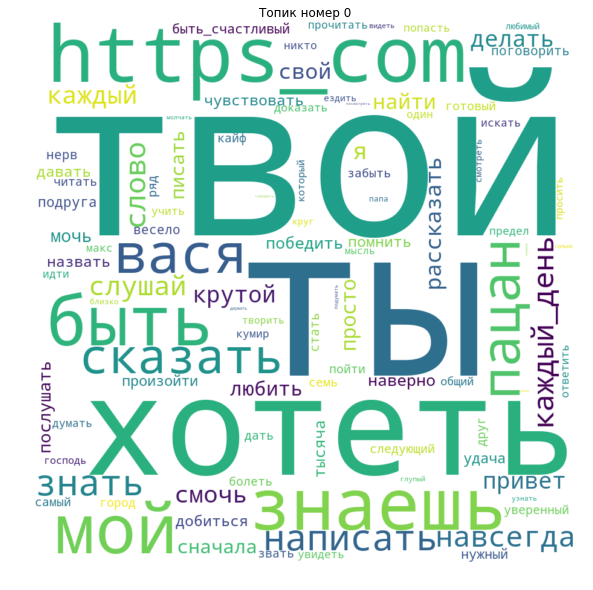

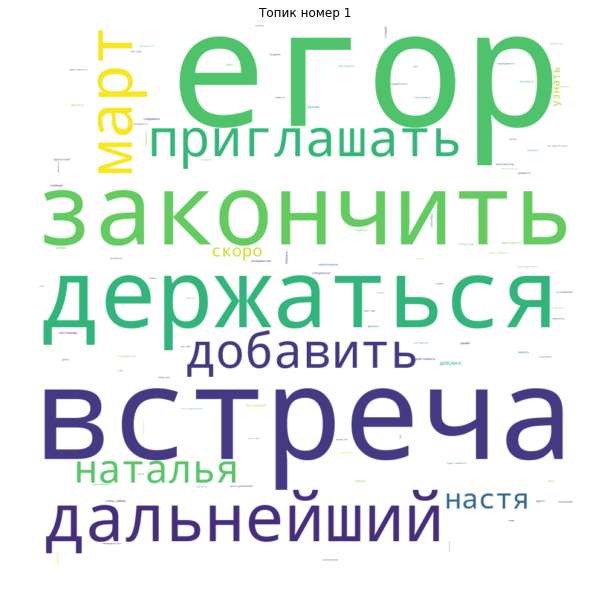

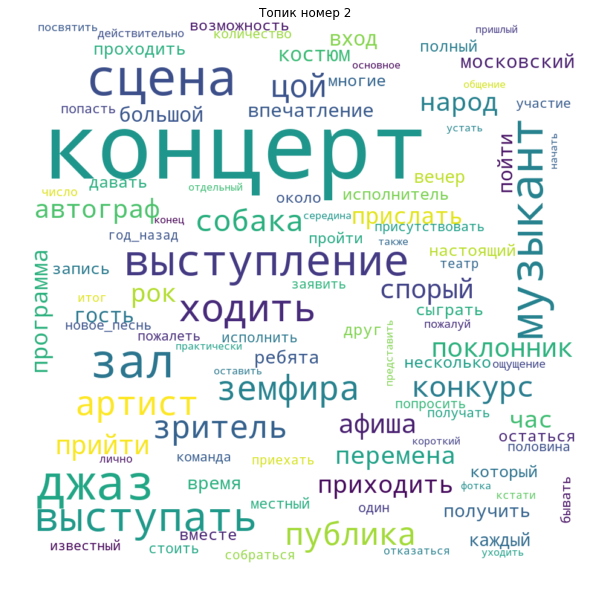

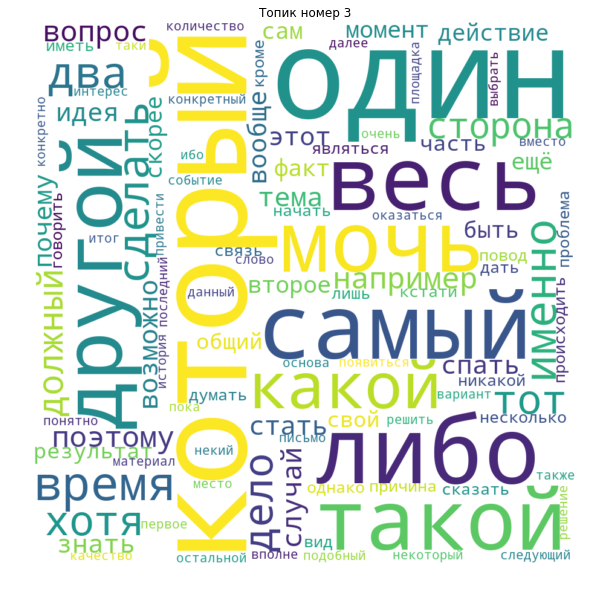

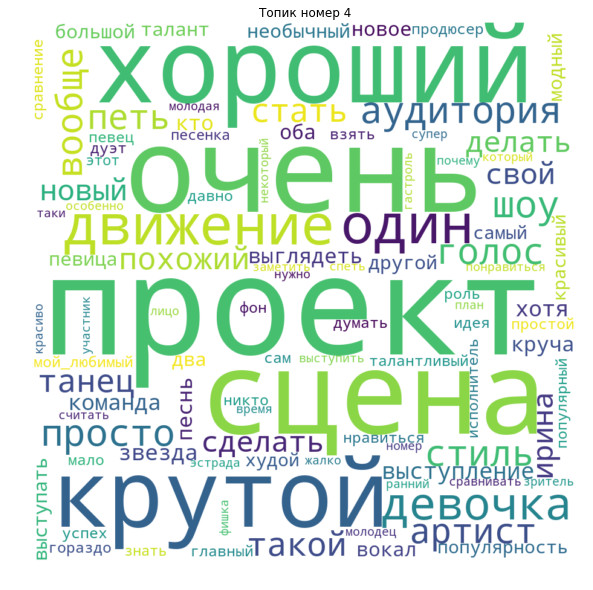

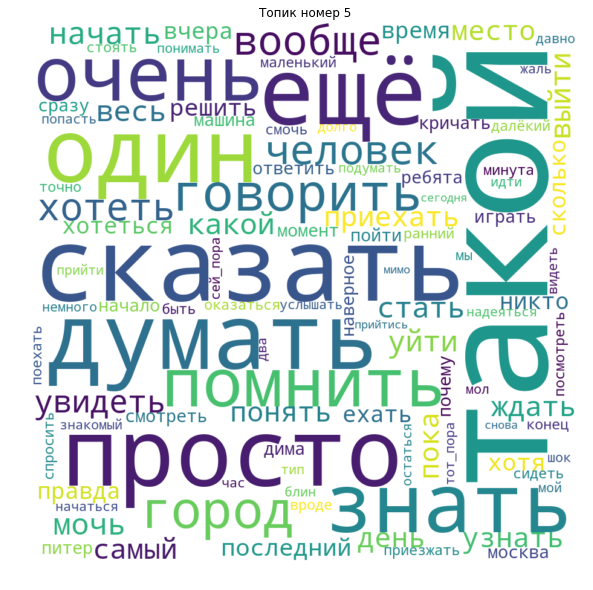

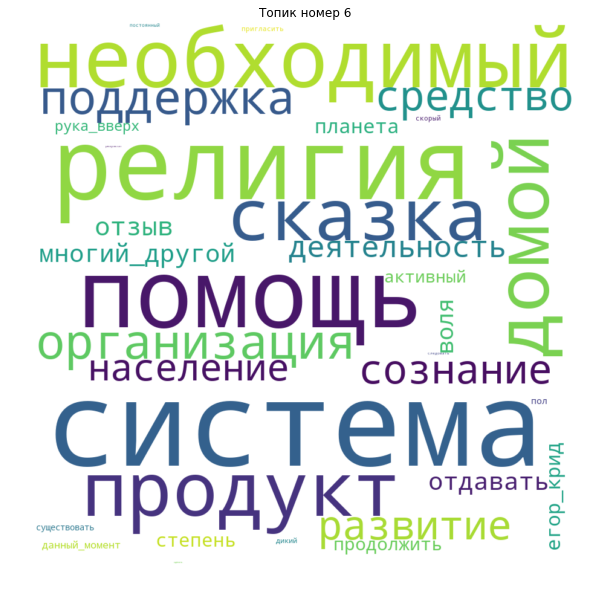

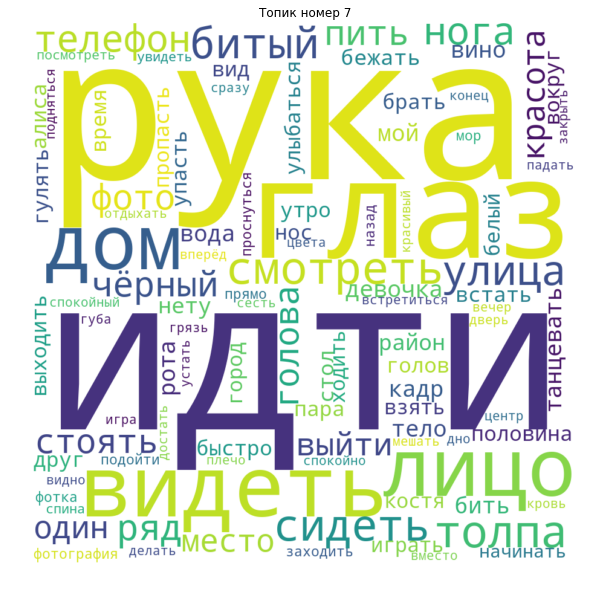

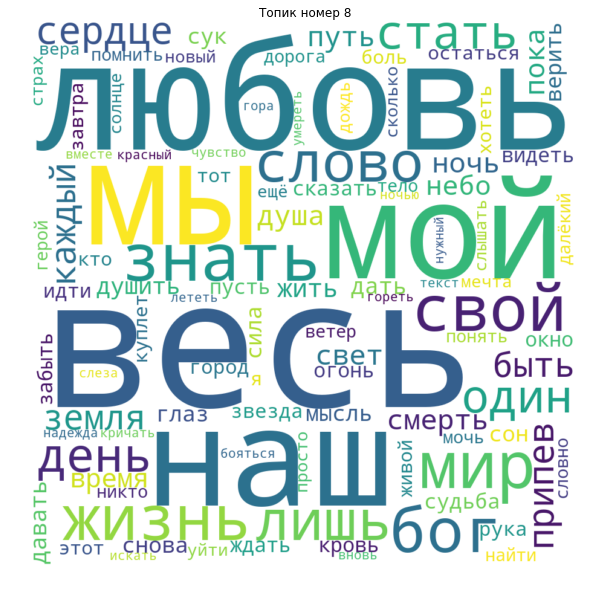

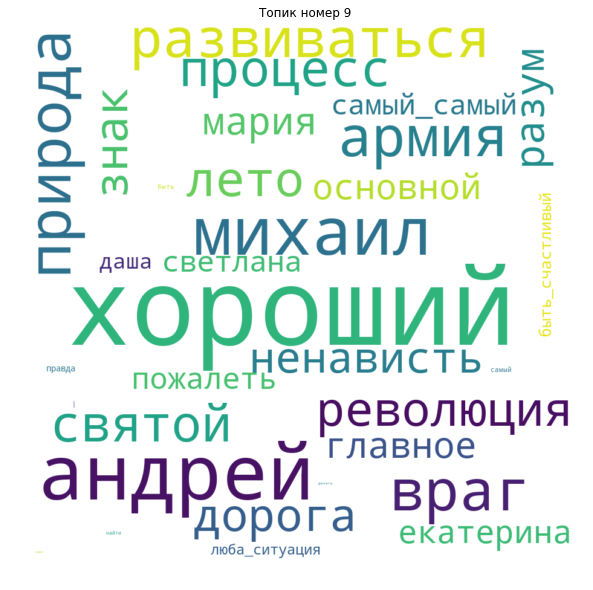

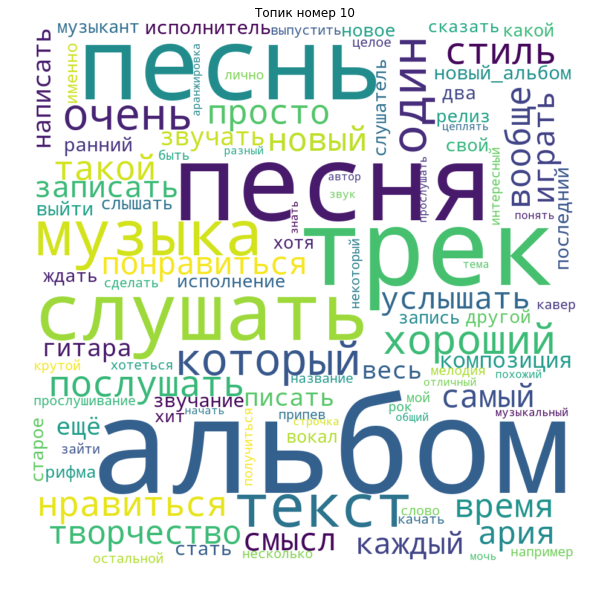

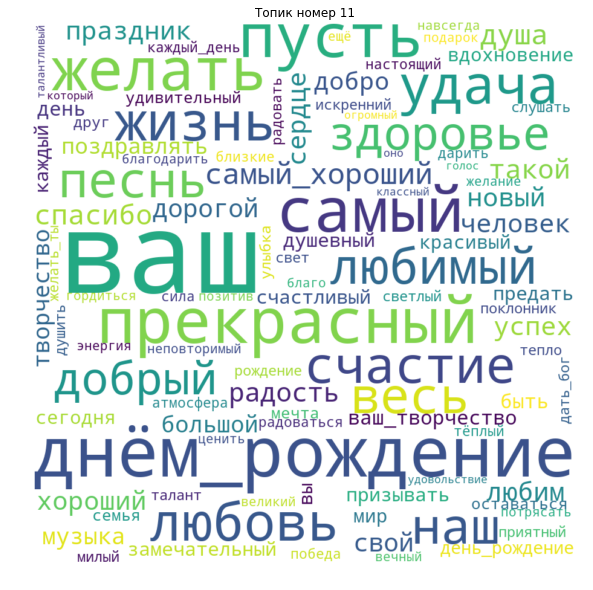

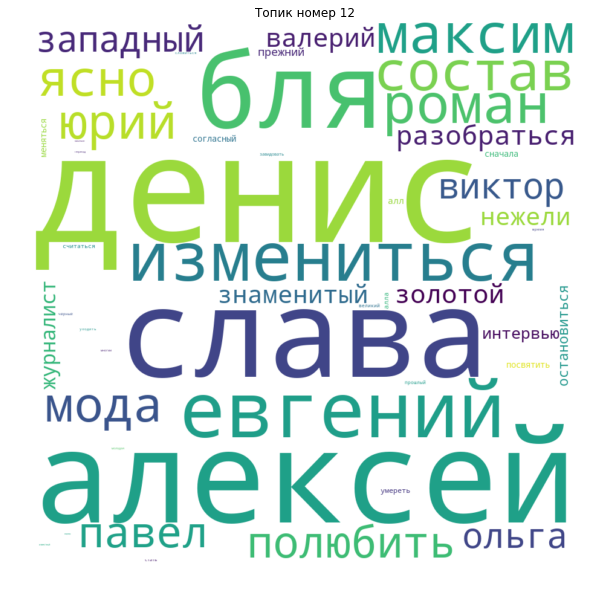

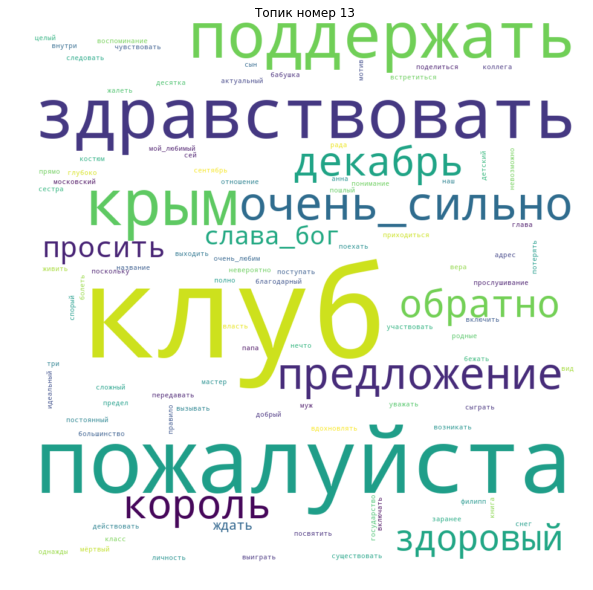

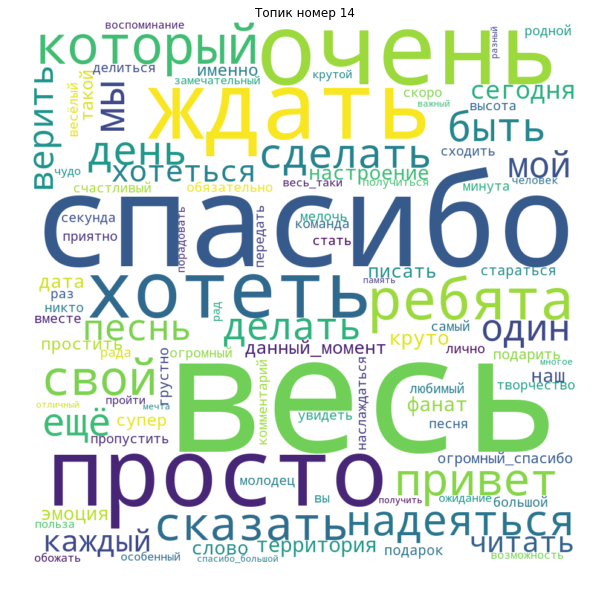

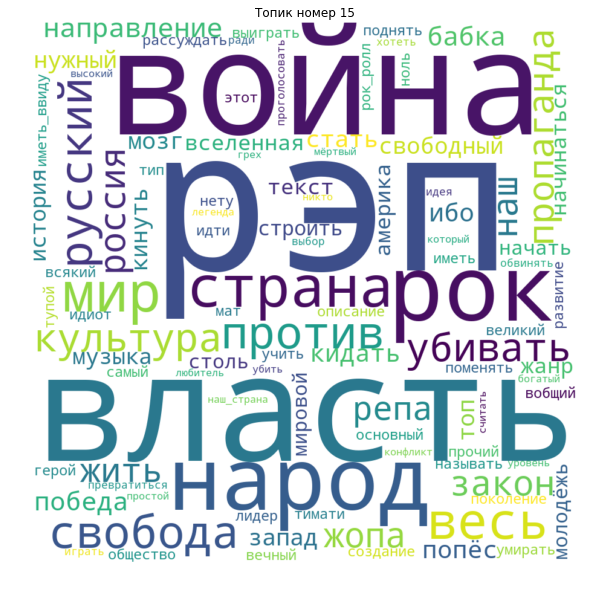

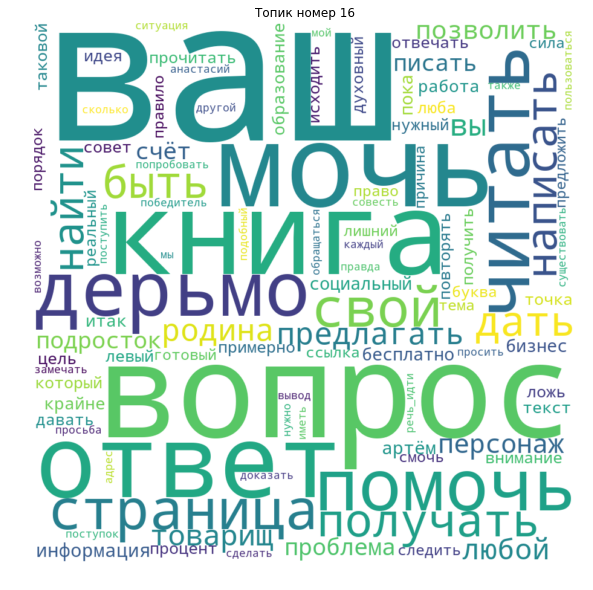

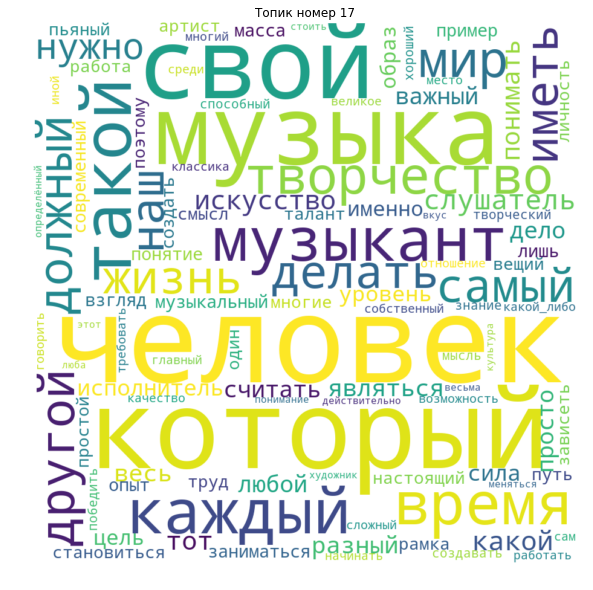

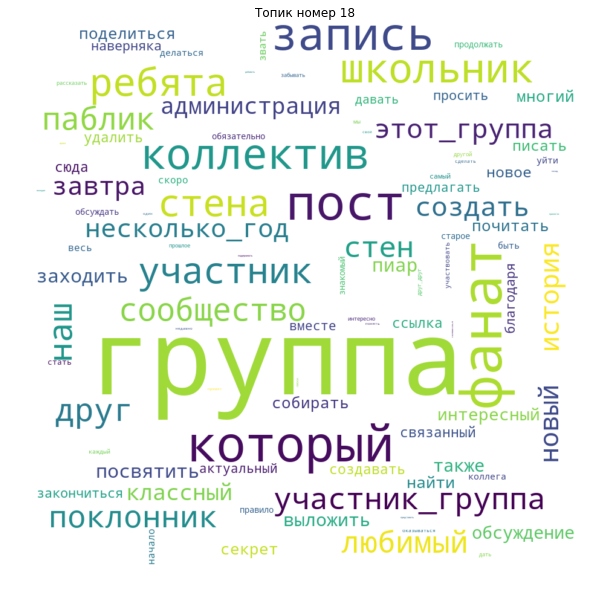

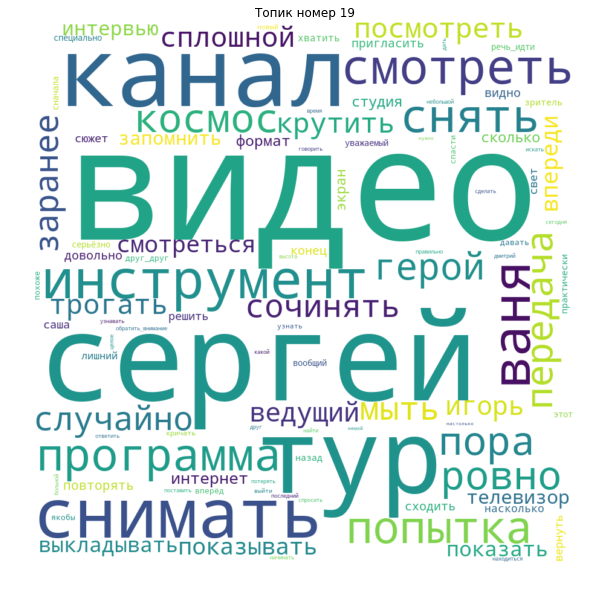

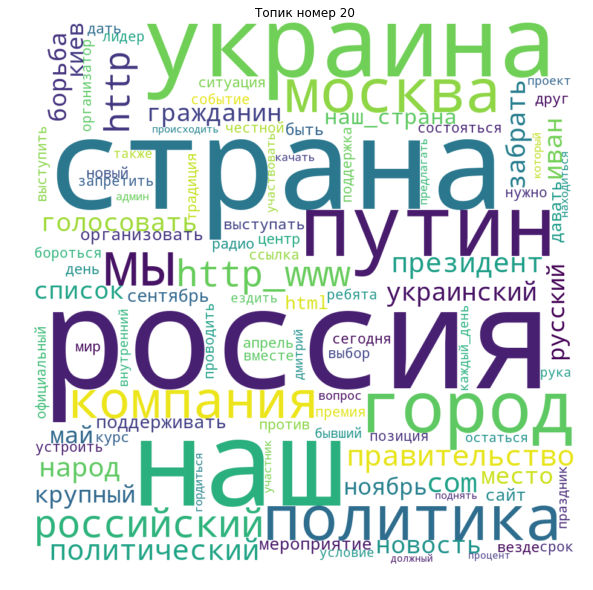

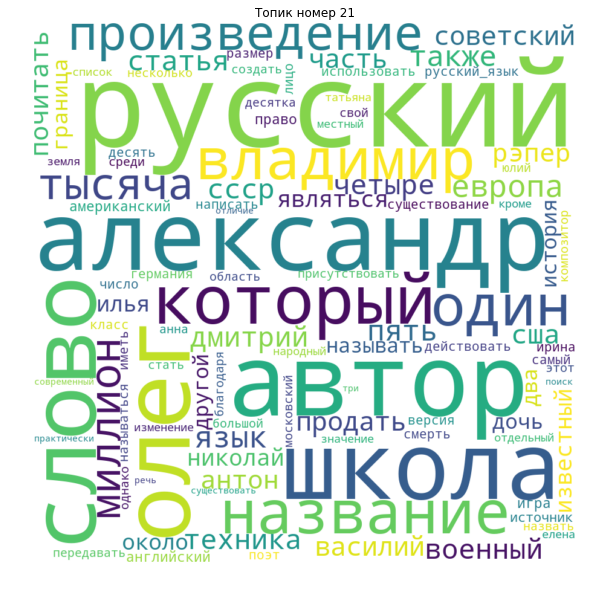

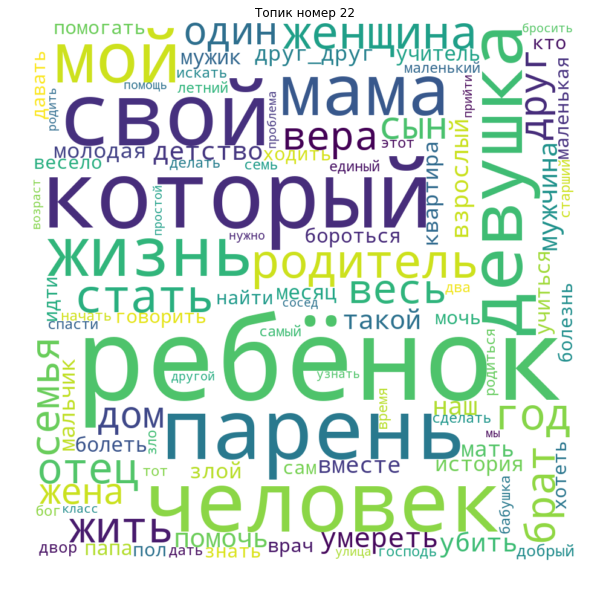

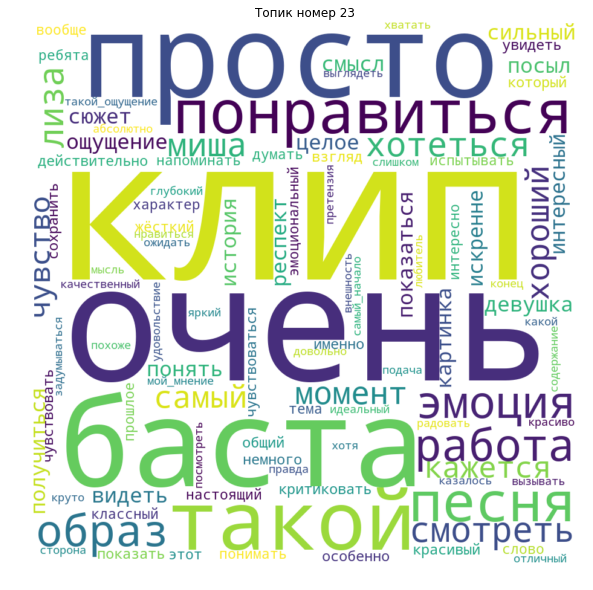

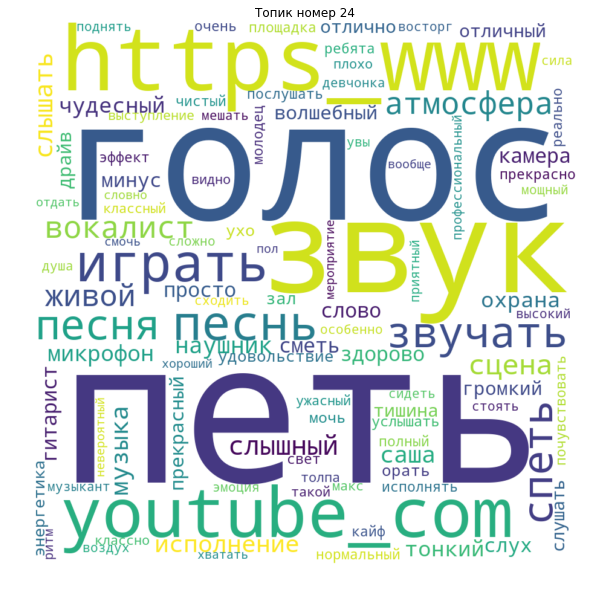

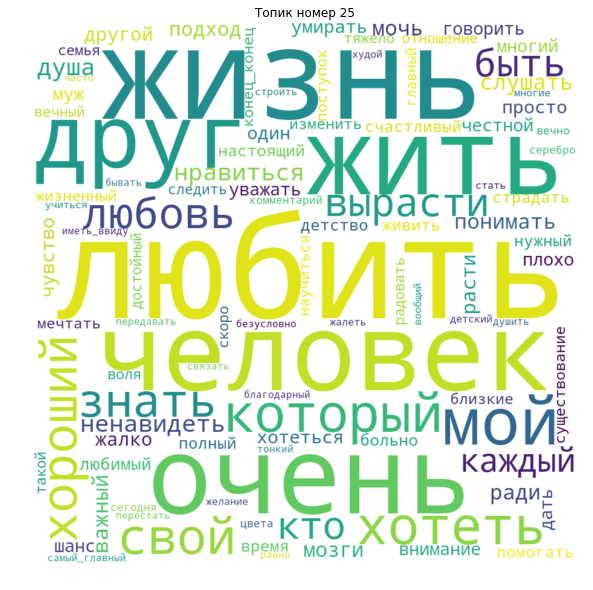

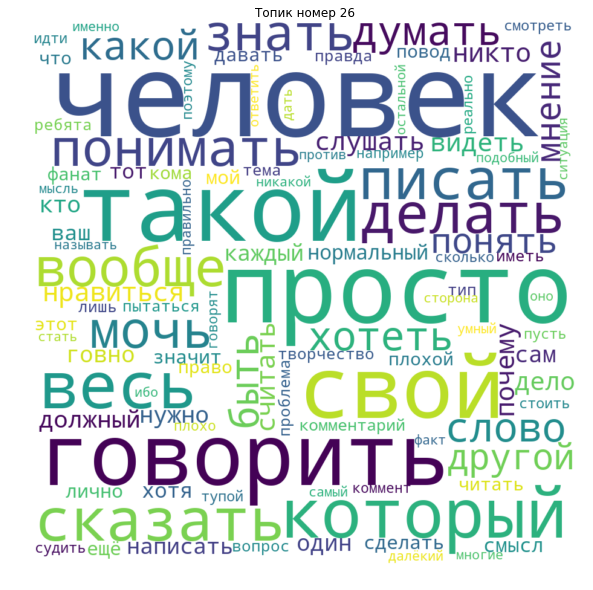

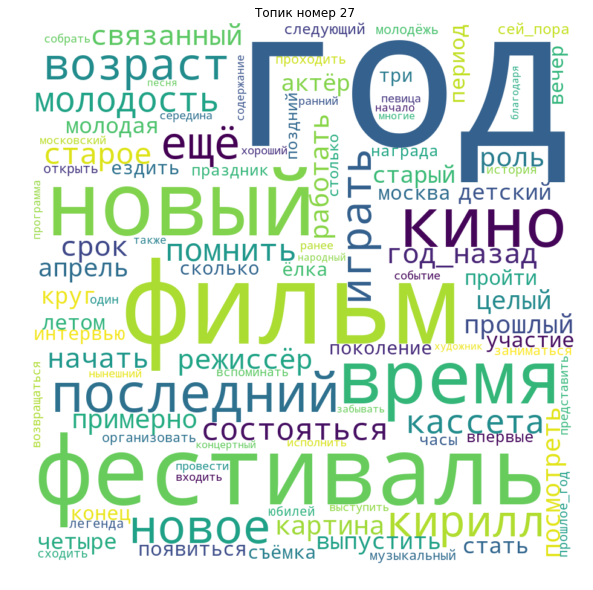

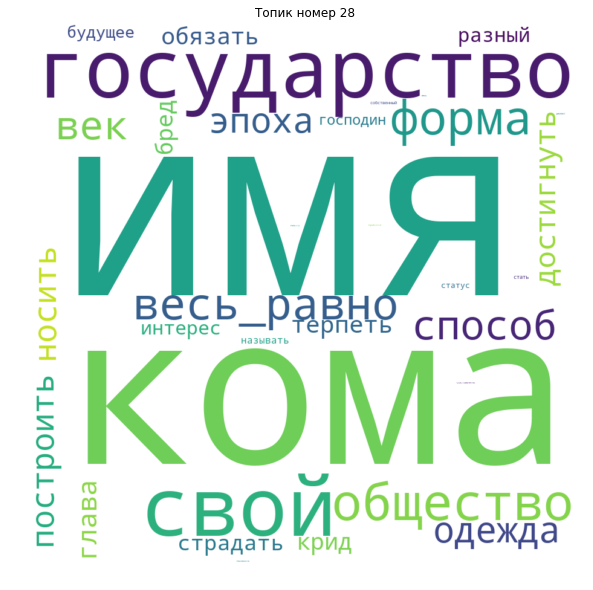

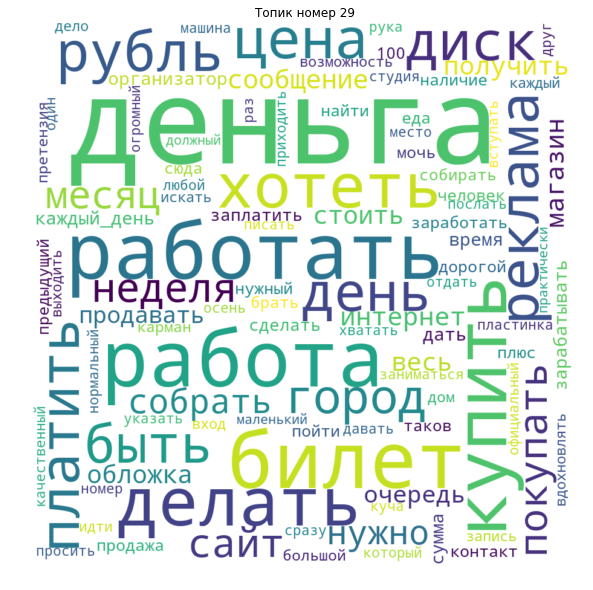

In [15]:
for i in range(30):
    plotWordCloud(topic_number=i)